# Работа 5: численное интегрирование табличной функции (VII.9.1)

Хотим для функции, заданной таблицей значений, вычислить определённый интеграл численными методами и уточнить результат с помощью экстраполяции Ричардсона.

Рассматриваем задачу **VII.9.1**. Дополнительно реализуем методы Ньютона–Котеса и квадратуры Гаусса:
1) метод прямоугольников
2) метод трапеций
3) метод Симпсона
4) метод Гаусса (2, 3, 4 точки)

> Поскольку функция задана таблично, для методов, которым нужны значения в промежуточных точках, будем использовать **линейную интерполяцию**.

## Справка: экстраполяция Ричардсона

Пусть $I$ — истинное значение интеграла, а $I(h)$ — приближение методом с шагом $h$.  
Для многих методов:
$$
I(h) = I + C h^p + o(h^p),
$$
где $p$ — **порядок метода**.

Тогда, имея два приближения на шагах $h$ и $h/2$, можно улучшить результат:
$$
I_R = I(h/2) + \frac{I(h/2) - I(h)}{2^p - 1}.
$$

## Данные из задания (VII.9.1)

### (a) Таблица для формулы Симпсона (интервал $[-1,1]$)
Точки: $x=-1,-0.75,\dots,1$ (шаг $0.25$).

### (b) Таблица для формулы трапеций (интервал $[0,2]$)
Точки: $x=0,0.25,\dots,2$ (шаг $0.25$).

In [62]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Таблица (a): [-1, 1] ---
x_a = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
f_a = [-1.0, -0.14, -0.032, 0.01, 0.0, 0.002, 0.003, 0.0031, 0.0029]

# --- Таблица (b): [0, 2] ---
x_b = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
f_b = [0.0, 0.028, 0.054, 0.078, 0.1, 0.2, 0.133, 0.145, 0.154]

print("Таблица (a):", len(x_a), "точек,", "h =", x_a[1]-x_a[0])
print("Таблица (b):", len(x_b), "точек,", "h =", x_b[1]-x_b[0])

Таблица (a): 9 точек, h = 0.25
Таблица (b): 9 точек, h = 0.25


## Табличная функция и линейная интерполяция

Если $x\in[x_i, x_{i+1}]$, то
$$
f(x)\approx f_i + \frac{f_{i+1}-f_i}{x_{i+1}-x_i}(x-x_i).
$$

In [63]:
class TabulatedFunction:
    def __init__(self, xs, ys):
        if len(xs) != len(ys):
            raise ValueError("xs и ys должны быть одинаковой длины")
        self.xs = [float(v) for v in xs]
        self.ys = [float(v) for v in ys]
        for i in range(1, len(self.xs)):
            if not (self.xs[i] > self.xs[i-1]):
                raise ValueError("xs должны быть строго возрастающими")

    def a(self):
        return self.xs[0]

    def b(self):
        return self.xs[-1]

    def eval(self, x):
        x = float(x)
        if x < self.xs[0] or x > self.xs[-1]:
            raise ValueError("x вне диапазона таблицы")

        # попадание в узел
        for i in range(len(self.xs)):
            if x == self.xs[i]:
                return self.ys[i]

        # поиск отрезка
        for i in range(len(self.xs) - 1):
            x0 = self.xs[i]
            x1 = self.xs[i+1]
            if x0 <= x <= x1:
                y0 = self.ys[i]
                y1 = self.ys[i+1]
                t = (x - x0) / (x1 - x0)
                return y0 + t * (y1 - y0)

        return self.ys[-1]


fa = TabulatedFunction(x_a, f_a)
fb = TabulatedFunction(x_b, f_b)

print("Диапазон (a):", fa.a(), fa.b())
print("Диапазон (b):", fb.a(), fb.b())
print("Пример интерполяции: f_a(0.125) =", fa.eval(0.125))

Диапазон (a): -1.0 1.0
Диапазон (b): 0.0 2.0
Пример интерполяции: f_a(0.125) = 0.001


## Сетка и шаг

Для всех методов удобно задавать число промежутков $n$, тогда $h=\frac{b-a}{n}$.

In [64]:
def uniform_grid(a, b, n):
    h = (b - a) / n
    xs = [a + i*h for i in range(n+1)]
    return xs, h

## 1) Метод прямоугольников (средние)

$$
I \approx h\sum_{i=0}^{n-1} f\!\left(\frac{x_i+x_{i+1}}{2}\right),
$$
порядок $p=2$.

In [65]:
def integrate_rect_mid(f, a, b, n):
    xs, h = uniform_grid(a, b, n)
    s = 0.0
    for i in range(n):
        xm = 0.5 * (xs[i] + xs[i+1])
        s += f.eval(xm)
    return s * h

## 2) Метод трапеций

$$
I \approx h\left(\frac{f(x_0)+f(x_n)}{2} + \sum_{i=1}^{n-1} f(x_i)\right),
$$
порядок $p=2$.

In [66]:
def integrate_trapezoid(f, a, b, n):
    xs, h = uniform_grid(a, b, n)
    s = 0.5 * (f.eval(xs[0]) + f.eval(xs[-1]))
    for i in range(1, n):
        s += f.eval(xs[i])
    return s * h

## 3) Метод Симпсона

$$
I \approx \frac{h}{3}\left(
f(x_0)+f(x_n)
+4\sum_{\text{нечётн. }i} f(x_i)
+2\sum_{\text{чётн. }i,\, i\neq 0,n} f(x_i)
\right),
$$
порядок $p=4$. Нужно чётное $n$.

In [67]:
def integrate_simpson(f, a, b, n):
    if n % 2 != 0:
        raise ValueError("Для Симпсона нужно чётное n")
    xs, h = uniform_grid(a, b, n)

    s0 = f.eval(xs[0]) + f.eval(xs[-1])
    s_odd = 0.0
    s_even = 0.0

    for i in range(1, n):
        if i % 2 == 1:
            s_odd += f.eval(xs[i])
        else:
            s_even += f.eval(xs[i])

    return (h / 3.0) * (s0 + 4.0 * s_odd + 2.0 * s_even)

## 4) Метод Гаусса на 2/3/4 точках

Интеграл на $[a,b]$ вычисляем по формуле с заменой $x=\frac{a+b}{2}+\frac{b-a}{2}t$.
Порядок для $m$ точек: $p=2m$.

Сделаем две версии:
- на одном отрезке $[a,b]$;
- составную (по $n$ подотрезкам).

In [68]:
def gauss_nodes_weights(m):
    if m == 2:
        t = [-1.0 / math.sqrt(3.0), 1.0 / math.sqrt(3.0)]
        w = [1.0, 1.0]
        return t, w
    if m == 3:
        t = [-math.sqrt(3.0/5.0), 0.0, math.sqrt(3.0/5.0)]
        w = [5.0/9.0, 8.0/9.0, 5.0/9.0]
        return t, w
    if m == 4:
        t = [-0.8611363115940526, -0.3399810435848563,
              0.3399810435848563,  0.8611363115940526]
        w = [0.3478548451374539, 0.6521451548625461,
             0.6521451548625461, 0.3478548451374539]
        return t, w
    raise ValueError("Поддерживаются только m=2,3,4")


def integrate_gauss_panel(f, a, b, m):
    t, w = gauss_nodes_weights(m)
    mid = 0.5 * (a + b)
    half = 0.5 * (b - a)

    s = 0.0
    for ti, wi in zip(t, w):
        x = mid + half * ti
        s += wi * f.eval(x)

    return half * s


def integrate_gauss_composite(f, a, b, n, m):
    xs, _ = uniform_grid(a, b, n)
    s = 0.0
    for i in range(n):
        s += integrate_gauss_panel(f, xs[i], xs[i+1], m)
    return s

## Экстраполяция Ричардсона

$$
I_R = I(h/2) + \frac{I(h/2)-I(h)}{2^p-1}.
$$

In [69]:
def richardson(I_h, I_h2, p):
    return I_h2 + (I_h2 - I_h) / (2.0**p - 1.0)

## VII.9.1(a) — Симпсон + Ричардсон

Берём $h=0.5$ (n=4) и $h/2=0.25$ (n=8). Для Симпсона $p=4$.

In [70]:
a1, b1 = fa.a(), fa.b()

I_s_h  = integrate_simpson(fa, a1, b1, n=4)
I_s_h2 = integrate_simpson(fa, a1, b1, n=8)
I_s_R  = richardson(I_s_h, I_s_h2, p=4)

print("VII.9.1(a), Симпсон:")
print("I(h=0.5)     =", I_s_h)
print("I(h=0.25)    =", I_s_h2)
print("I_Richardson =", I_s_R)

VII.9.1(a), Симпсон:
I(h=0.5)     = -0.18551666666666666
I(h=0.25)    = -0.12955833333333333
I_Richardson = -0.1258277777777778


## VII.9.1(b) — трапеции + Ричардсон

Берём $h=0.5$ (n=4) и $h/2=0.25$ (n=8). Для трапеций $p=2$.

In [71]:
a2, b2 = fb.a(), fb.b()

I_t_h  = integrate_trapezoid(fb, a2, b2, n=4)
I_t_h2 = integrate_trapezoid(fb, a2, b2, n=8)
I_t_R  = richardson(I_t_h, I_t_h2, p=2)

print("VII.9.1(b), Трапеции:")
print("I(h=0.5)     =", I_t_h)
print("I(h=0.25)    =", I_t_h2)
print("I_Richardson =", I_t_R)

VII.9.1(b), Трапеции:
I(h=0.5)     = 0.182
I(h=0.25)    = 0.20375
I_Richardson = 0.211


## Сравнение всех методов на обеих таблицах

Считаем на шагах $h=0.5$ (n=4) и $h=0.25$ (n=8) и делаем Ричардсона.

Порядки:
- прямоугольники (средние): $p=2$
- трапеции: $p=2$
- Симпсон: $p=4$
- Гаусс (m точек): $p=2m$

In [72]:
import pandas as pd

def pack_to_dataframe(pack, table_name):
    rows = []
    for method, I_h, I_h2, I_R in pack:
        rows.append({
            "Таблица": table_name,
            "Метод": method,
            "I(h)": I_h,
            "I(h/2)": I_h2,
            "I_R (Ричардсон)": I_R
        })

    df = pd.DataFrame(rows)

    def fmt(v):
        if v is None:
            return ""
        if isinstance(v, float):
            return f"{v:.12g}"
        return str(v)

    for col in ["I(h)", "I(h/2)", "I_R (Ричардсон)"]:
        df[col] = df[col].apply(fmt)

    return df

df_a = pack_to_dataframe(pack_a, "a: [-1, 1]")
df_b = pack_to_dataframe(pack_b, "b: [0, 2]")

df_all = pd.concat([df_a, df_b], ignore_index=True)
df_all

,Таблица,Метод,I(h),I(h/2),I_R (Ричардсон)
0,"a: [-1, 1]",Прямоугольники (средние),-0.06245,-0.1631125,-0.196666666667
1,"a: [-1, 1]",Трапеции,-0.263775,-0.1631125,-0.129558333333
2,"a: [-1, 1]",Симпсон,-0.185516666667,-0.129558333333,-0.125827777778
3,"a: [-1, 1]",Гаусс 2т (1 отрезок),-0.0623843761822,nan,nan
4,"a: [-1, 1]",Гаусс 3т (1 отрезок),-0.123073455292,nan,nan
5,"a: [-1, 1]",Гаусс 4т (1 отрезок),-0.182438156285,nan,nan
6,"a: [-1, 1]",Гаусс 2т (составной),-0.178685042945,-0.1631125,-0.16207433047
7,"a: [-1, 1]",Гаусс 3т (составной),-0.149086485797,-0.1631125,-0.163335135146
8,"a: [-1, 1]",Гаусс 4т (составной),-0.167394165069,-0.1631125,-0.163095709157
9,"b: [0, 2]",Прямоугольники (средние),0.2255,0.20375,0.1965


## График: как меняется $I(h)$ при уменьшении шага

Точного значения интеграла у нас нет, но можно посмотреть, как стабилизируются результаты при уменьшении $h$.

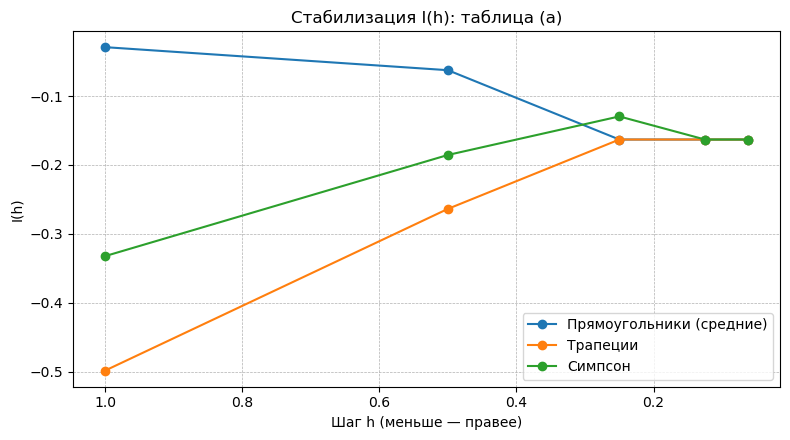

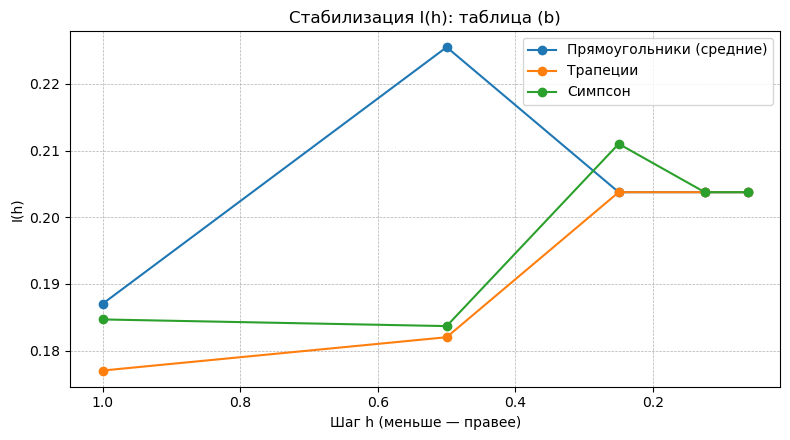

In [73]:
def sweep_ns():
    return [2, 4, 8, 16, 32]

def values_vs_h(f):
    a, b = f.a(), f.b()
    ns = sweep_ns()
    hs = []
    rect = []
    trap = []
    simp = []
    for n in ns:
        h = (b - a) / n
        hs.append(h)
        rect.append(integrate_rect_mid(f, a, b, n))
        trap.append(integrate_trapezoid(f, a, b, n))
        if n % 2 == 0:
            simp.append(integrate_simpson(f, a, b, n))
        else:
            simp.append(np.nan)
    return np.array(hs), np.array(rect), np.array(trap), np.array(simp)

def plot_values(f, title):
    hs, rect, trap, simp = values_vs_h(f)

    plt.figure(figsize=(8, 4.5))
    plt.plot(hs, rect, marker="o", label="Прямоугольники (средние)")
    plt.plot(hs, trap, marker="o", label="Трапеции")
    plt.plot(hs, simp, marker="o", label="Симпсон")

    plt.gca().invert_xaxis()
    plt.xlabel("Шаг h (меньше — правее)")
    plt.ylabel("I(h)")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_values(fa, "Стабилизация I(h): таблица (a)")
plot_values(fb, "Стабилизация I(h): таблица (b)")

## Выводы

- Для задачи VII.9.1 выполнены расчёты по указанным формулам (Симпсон и трапеции) и применена экстраполяция Ричардсона.
- Реализованы основные методы Ньютона–Котеса: средние прямоугольники, трапеции, Симпсон.
- Реализованы квадратуры Гаусса на 2/3/4 точках (одна панель и составной вариант).
- При табличной функции точность методов с промежуточными точками зависит от выбранной интерполяции (в работе — линейная).